## Predicciones de fraude a partir de una Regresión Logística

In [1]:
# Importacion de paquetes necesarios para trabajar.
import pandas as pd
import numpy as np

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [26]:
import sklearn 
print(sklearn.__version__)

1.0.1


In [2]:
transaction_train = pd.read_csv('train_transaction.csv')
transaction_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
identity_train = pd.read_csv('train_identity.csv')
identity_train.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
join_train_values = transaction_train.merge(identity_train,on='TransactionID',how='left')
join_train_values.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [5]:
# Eliminacion de los dataframes viejos para liberar RAM
del transaction_train
del identity_train

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Me fijo cuales son las features con mas correlacion
data = abs(join_train_values.corr()['isFraud']).nlargest(11)

In [13]:
df =data.drop(axis=0,index='isFraud')
df = pd.DataFrame(df)
df

,isFraud
V257,0.383060
V246,0.366878
V244,0.364129
V242,0.360590
V201,0.328005
V200,0.318783
V189,0.308219
V188,0.303582
V258,0.297151
V45,0.281832


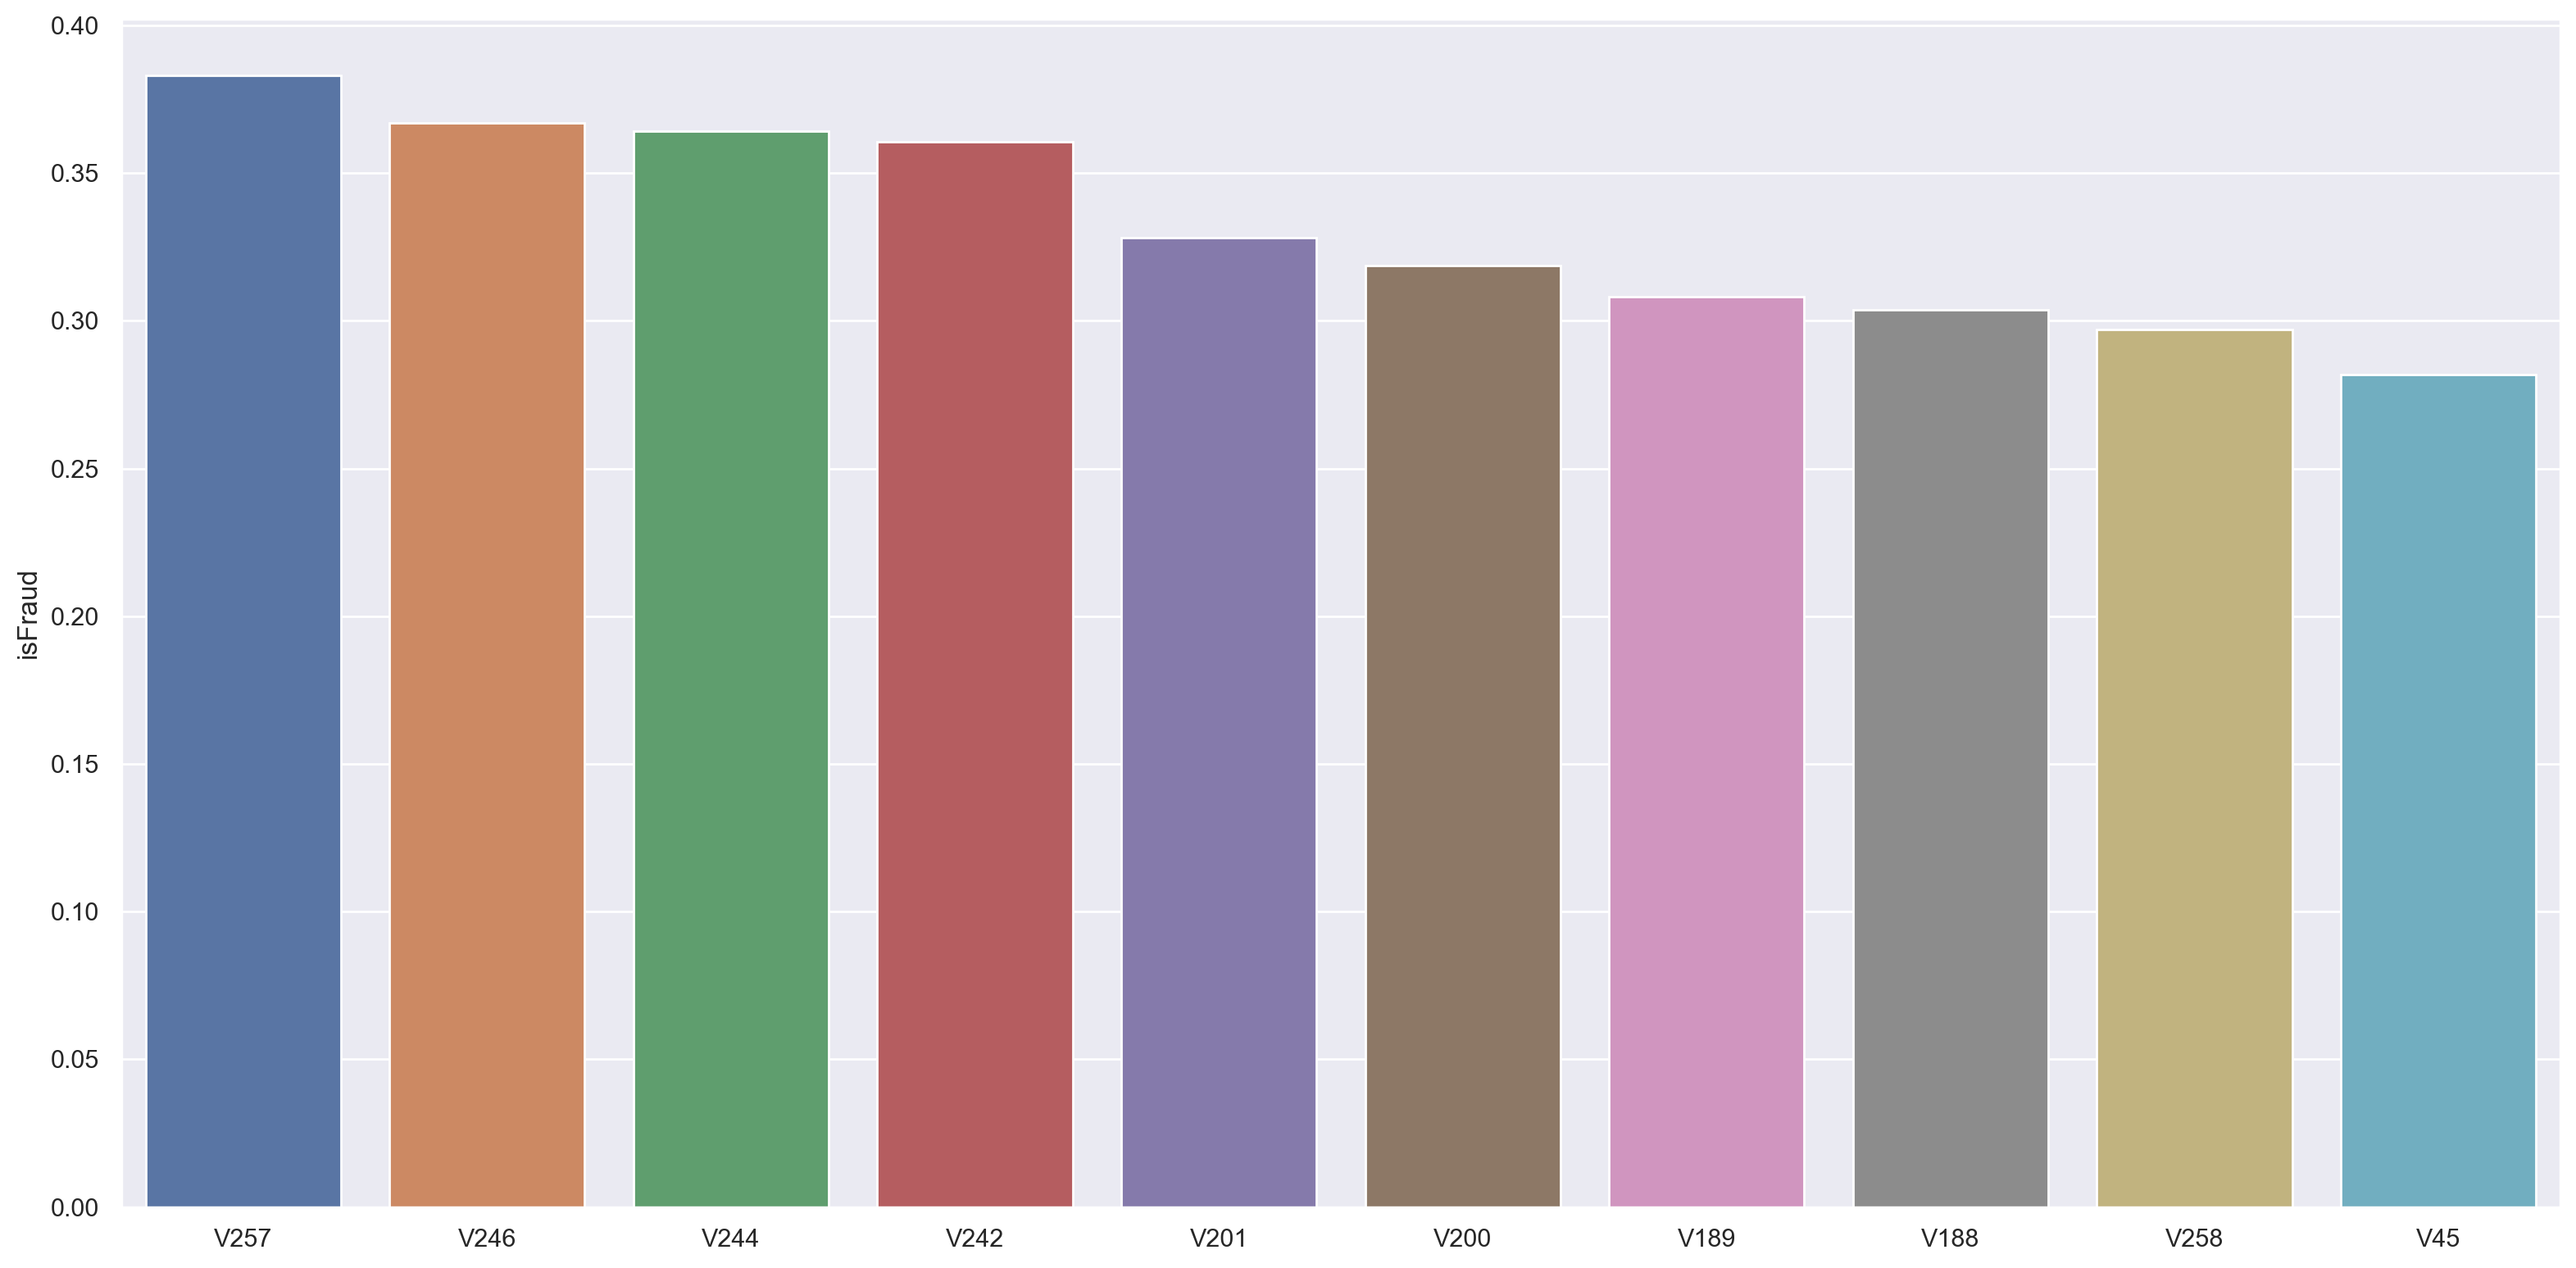

In [15]:
sns.set(rc={"figure.dpi":200,'figure.figsize':(19.2,9.6)})
ax = sns.barplot(x=df.index, y="isFraud", data=df)
ax.set_title("Features mas imp",fontsize=15)
plt.legend(labels=["No es fraude","Fraude"], title = "Casos")
ax.set_xlabel("Codigo",fontsize=14)
ax.set_ylabel("Cantidad",fontsize=14)

Para la imputacion de nulos para aquellos _features_ categoricos, se usará la palabra "deconcido"

In [31]:
for column in join_train_values.columns:
    if join_train_values[column].dtype == 'object':
        join_train_values[column].fillna('desconocido',inplace=True)

In [32]:
del join_train_values['TransactionID']
join_train_values

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
1,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
2,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
3,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
4,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
590536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
590537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
590538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido


Para la parte de validation y train, separaré en 70-30 mi dataset 

In [33]:
# Separo mi dataset en train y validation
train = join_train_values.loc[join_train_values.index <= (len(join_train_values)*0.7)]
validation = join_train_values.loc[join_train_values.index >= (len(join_train_values)*0.7)]

In [34]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [35]:
validation.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
413378,0,10438003,49.0,W,7239,452.0,150.0,mastercard,117.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
413379,1,10438017,1265.5,W,18227,583.0,150.0,visa,226.0,credit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
413380,0,10438043,50.0,H,11919,170.0,150.0,mastercard,224.0,debit,...,mobile safari generic,32.0,2436x1125,match_status:1,T,F,F,T,mobile,iOS Device
413381,0,10438052,161.0,W,2377,203.0,150.0,visa,166.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
413382,0,10438065,88.0,W,7919,194.0,150.0,mastercard,166.0,debit,...,desconocido,NaN,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido


In [36]:
# Aquellas columnas que me parecen importantes, les realizo un hot-encoding y aquellas que no, un label enconding
# Estas columnas que parecerian ser relevantes son ProductCD,card4,card6,P_emaildomain,R_emaildomain,
#id_23, id_30,id_34,DeviceType

In [37]:
# Hago un label enconding para aquellas columnas que no esten en labels_hot_encoding
ordinal_dic = {}
for column in train.columns:
    if train[column].dtypes == object:
        ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
        ordinal_dic[column] = ordinal_encoder
        train[column] = ordinal_encoder.fit_transform(train[column].astype(str).values.reshape(-1,1))

<ipython-input-37-e22b18326ee1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = ordinal_encoder.fit_transform(train[column].astype(str).values.reshape(-1,1))
<ipython-input-37-e22b18326ee1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = ordinal_encoder.fit_transform(train[column].astype(str).values.reshape(-1,1))
<ipython-input-37-e22b18326ee1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

<ipython-input-37-e22b18326ee1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = ordinal_encoder.fit_transform(train[column].astype(str).values.reshape(-1,1))
<ipython-input-37-e22b18326ee1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = ordinal_encoder.fit_transform(train[column].astype(str).values.reshape(-1,1))
<ipython-input-37-e22b18326ee1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [38]:
train

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,4.0,13926,NaN,150.0,2.0,142.0,1.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
1,0,86401,29.0,4.0,2755,404.0,150.0,3.0,102.0,1.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
2,0,86469,59.0,4.0,4663,490.0,150.0,4.0,166.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
3,0,86499,50.0,4.0,18132,567.0,150.0,3.0,117.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
4,0,86506,50.0,1.0,4497,514.0,150.0,3.0,102.0,1.0,...,102.0,32.0,114.0,4.0,1.0,0.0,1.0,1.0,2.0,821.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413374,0,10437974,226.0,4.0,10112,360.0,150.0,4.0,166.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
413375,0,10437990,72.0,4.0,11849,271.0,150.0,4.0,226.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
413376,0,10437992,35.0,4.0,11919,170.0,150.0,3.0,224.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
413377,0,10437996,59.0,4.0,17480,181.0,150.0,4.0,226.0,1.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0


In [40]:
train.head(4)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,4.0,13926,NaN,150.0,2.0,142.0,1.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
1,0,86401,29.0,4.0,2755,404.0,150.0,3.0,102.0,1.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
2,0,86469,59.0,4.0,4663,490.0,150.0,4.0,166.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0
3,0,86499,50.0,4.0,18132,567.0,150.0,3.0,117.0,2.0,...,59.0,NaN,183.0,0.0,2.0,2.0,2.0,2.0,0.0,1489.0


In [41]:
train.fillna(0,inplace=True)

C:\Users\alejo\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [42]:
validation.fillna(0,inplace=True)

In [43]:
model = LogisticRegression(random_state=0)

In [44]:
label = train.isFraud
del train['isFraud']

In [45]:
model.fit(train,label)

C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [46]:
validation_label = validation.isFraud
del validation['isFraud']

In [47]:
for c in validation.columns:
    if (c) in ordinal_dic:
        print("Procesando: ", c)
        validation_encoded = ordinal_dic[c].transform(validation[c].astype(str).values.reshape(-1,1))
        validation[c] = validation_encoded

<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded


Procesando:  ProductCD
Procesando:  card4
Procesando:  card6
Procesando:  P_emaildomain


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Procesando:  R_emaildomain
Procesando:  M1
Procesando:  M2
Procesando:  M3
Procesando:  M4


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Procesando:  M5
Procesando:  M6
Procesando:  M7
Procesando:  M8
Procesando:  M9


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Procesando:  id_12
Procesando:  id_15
Procesando:  id_16
Procesando:  id_23
Procesando:  id_27


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Procesando:  id_28
Procesando:  id_29
Procesando:  id_30
Procesando:  id_31


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Procesando:  id_33
Procesando:  id_34
Procesando:  id_35
Procesando:  id_36


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded
<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Procesando:  id_37
Procesando:  id_38
Procesando:  DeviceType
Procesando:  DeviceInfo


<ipython-input-47-96d084cb467f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation[c] = validation_encoded


In [48]:
validation.shape

(177162, 432)

In [49]:
print(classification_report(validation_label, model.predict(validation)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    171037
           1       0.00      0.00      0.00      6125

    accuracy                           0.96    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.96      0.95    177162



In [50]:
roc_auc_score(validation_label, model.predict_proba(validation)[:,1])

0.664945700136729

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [52]:
distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'none'])

In [53]:
clf = RandomizedSearchCV(model, distributions, random_state=0,verbose=100,n_iter=10,n_jobs=1,cv=3,scoring='roc_auc')

In [54]:
search = clf.fit(train,label)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START C=2.195254015709299, penalty=none..........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 1/10] END C=2.195254015709299, penalty=none;, score=0.681 total time=  18.8s
[CV 2/3; 1/10] START C=2.195254015709299, penalty=none..........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 1/10] END C=2.195254015709299, penalty=none;, score=0.647 total time=  17.2s
[CV 3/3; 1/10] START C=2.195254015709299, penalty=none..........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 1/10] END C=2.195254015709299, penalty=none;, score=0.670 total time=  17.1s
[CV 1/3; 2/10] START C=3.3770629943240693, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 2/10] END C=3.3770629943240693, penalty=none;, score=0.681 total time=  16.1s
[CV 2/3; 2/10] START C=3.3770629943240693, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 2/10] END C=3.3770629943240693, penalty=none;, score=0.647 total time=  17.1s
[CV 3/3; 2/10] START C=3.3770629943240693, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 2/10] END C=3.3770629943240693, penalty=none;, score=0.670 total time=  16.4s
[CV 1/3; 3/10] START C=2.1795327319875875, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 3/10] END C=2.1795327319875875, penalty=none;, score=0.681 total time=  16.1s
[CV 2/3; 3/10] START C=2.1795327319875875, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 3/10] END C=2.1795327319875875, penalty=none;, score=0.647 total time=  16.5s
[CV 3/3; 3/10] START C=2.1795327319875875, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 3/10] END C=2.1795327319875875, penalty=none;, score=0.670 total time=  16.3s
[CV 1/3; 4/10] START C=2.4942547871438894, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 4/10] END C=2.4942547871438894, penalty=l2;, score=0.565 total time=  16.1s
[CV 2/3; 4/10] START C=2.4942547871438894, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 4/10] END C=2.4942547871438894, penalty=l2;, score=0.639 total time=  17.4s
[CV 3/3; 4/10] START C=2.4942547871438894, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 4/10] END C=2.4942547871438894, penalty=l2;, score=0.656 total time=  16.9s
[CV 1/3; 5/10] START C=1.75034884505077, penalty=l2.............................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 5/10] END C=1.75034884505077, penalty=l2;, score=0.672 total time=  16.0s
[CV 2/3; 5/10] START C=1.75034884505077, penalty=l2.............................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 5/10] END C=1.75034884505077, penalty=l2;, score=0.691 total time=  17.7s
[CV 3/3; 5/10] START C=1.75034884505077, penalty=l2.............................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 5/10] END C=1.75034884505077, penalty=l2;, score=0.661 total time=  17.0s
[CV 1/3; 6/10] START C=0.22685190926977272, penalty=l2..........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 6/10] END C=0.22685190926977272, penalty=l2;, score=0.676 total time=  15.4s
[CV 2/3; 6/10] START C=0.22685190926977272, penalty=l2..........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 6/10] END C=0.22685190926977272, penalty=l2;, score=0.644 total time=  19.7s
[CV 3/3; 6/10] START C=0.22685190926977272, penalty=l2..........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 6/10] END C=0.22685190926977272, penalty=l2;, score=0.655 total time=  16.9s
[CV 1/3; 7/10] START C=1.5337660753031108, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 7/10] END C=1.5337660753031108, penalty=l2;, score=0.564 total time=  16.3s
[CV 2/3; 7/10] START C=1.5337660753031108, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 7/10] END C=1.5337660753031108, penalty=l2;, score=0.645 total time=  19.1s
[CV 3/3; 7/10] START C=1.5337660753031108, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 7/10] END C=1.5337660753031108, penalty=l2;, score=0.652 total time=  15.5s
[CV 1/3; 8/10] START C=3.2486749151019727, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 8/10] END C=3.2486749151019727, penalty=l2;, score=0.598 total time=  15.8s
[CV 2/3; 8/10] START C=3.2486749151019727, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 8/10] END C=3.2486749151019727, penalty=l2;, score=0.644 total time=  17.4s
[CV 3/3; 8/10] START C=3.2486749151019727, penalty=l2...........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 8/10] END C=3.2486749151019727, penalty=l2;, score=0.658 total time=  14.9s
[CV 1/3; 9/10] START C=2.2721782443757292, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 9/10] END C=2.2721782443757292, penalty=none;, score=0.681 total time=  15.3s
[CV 2/3; 9/10] START C=2.2721782443757292, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 9/10] END C=2.2721782443757292, penalty=none;, score=0.647 total time=  16.7s
[CV 3/3; 9/10] START C=2.2721782443757292, penalty=none.........................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 9/10] END C=2.2721782443757292, penalty=none;, score=0.670 total time=  15.8s
[CV 1/3; 10/10] START C=3.34431505414951, penalty=l2............................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 10/10] END C=3.34431505414951, penalty=l2;, score=0.682 total time=  14.9s
[CV 2/3; 10/10] START C=3.34431505414951, penalty=l2............................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 10/10] END C=3.34431505414951, penalty=l2;, score=0.645 total time=  17.9s
[CV 3/3; 10/10] START C=3.34431505414951, penalty=l2............................


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 10/10] END C=3.34431505414951, penalty=l2;, score=0.656 total time=  16.3s


C:\Users\alejo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
print(classification_report(validation_label, search.predict(validation)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    171037
           1       0.13      0.01      0.02      6125

    accuracy                           0.96    177162
   macro avg       0.55      0.50      0.50    177162
weighted avg       0.94      0.96      0.95    177162



In [56]:
roc_auc_score(validation_label, search.predict_proba(validation)[:,1])

0.6770678997371734

In [57]:
import pickle
with open('model_backup', 'wb') as model_backup_file:
    pickle.dump(search, model_backup_file)

In [58]:
transaction_test = pd.read_csv('test_transaction.csv')
transaction_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
identity_test = pd.read_csv('test_identity.csv')
identity_test.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [60]:
joined_test_data = transaction_test.merge(identity_test,on='TransactionID',how='left')
joined_test_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
del transaction_test
del identity_test

In [62]:
for column in joined_test_data.columns:
    if joined_test_data[column].dtype == 'object':
        joined_test_data[column].fillna('desconocido',inplace=True)

In [63]:
joined_test_data.fillna(0,inplace=True)

In [64]:
transaction_ids = joined_test_data.TransactionID
del joined_test_data['TransactionID']

In [65]:
col = {}
for c in joined_test_data.columns:
    if c not in join_train_values.columns:
        print(c)

id-01
id-02
id-03
id-04
id-05
id-06
id-07
id-08
id-09
id-10
id-11
id-12
id-13
id-14
id-15
id-16
id-17
id-18
id-19
id-20
id-21
id-22
id-23
id-24
id-25
id-26
id-27
id-28
id-29
id-30
id-31
id-32
id-33
id-34
id-35
id-36
id-37
id-38


In [66]:
c  = {"id-01":"id_01",
"id-02":"id_02",
"id-03":"id_03",
"id-04":"id_04",
"id-05":"id_05",
"id-06":"id_06",
"id-07":"id_07",
"id-08":"id_08",
"id-09":"id_09",
"id-10":"id_10",
"id-11":"id_11",
"id-12":"id_12",
"id-13":"id_13",
"id-14":"id_14",
"id-15":"id_15",
"id-16":"id_16",
"id-17":"id_17",
"id-18":"id_18",
"id-19":"id_19",
"id-20":"id_20",
"id-21":"id_21",
"id-22":"id_22",
"id-23":"id_23",
"id-24":"id_24",
"id-25":"id_25",
"id-26":"id_26",
"id-27":"id_27",
"id-28":"id_28",
"id-29":"id_29",
"id-30":"id_30",
"id-31":"id_31",
"id-32":"id_32",
"id-33":"id_33",
"id-34":"id_34",
"id-35":"id_35",
"id-36":"id_36",
"id-37":"id_37",
"id-38":"id_38",}

In [67]:
joined_test_data.rename(columns=c,inplace=True)

In [68]:
joined_test_data.dtypes

TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 432, dtype: object

In [69]:
for c in joined_test_data.columns:
    if (c) in ordinal_dic:
        print("Procesando: ", c)
        test_encoded = ordinal_dic[c].transform(joined_test_data[c].astype(str).values.reshape(-1,1))
        joined_test_data[c] = test_encoded

Procesando:  ProductCD
Procesando:  card4
Procesando:  card6
Procesando:  P_emaildomain
Procesando:  R_emaildomain
Procesando:  M1
Procesando:  M2
Procesando:  M3
Procesando:  M4
Procesando:  M5
Procesando:  M6
Procesando:  M7
Procesando:  M8
Procesando:  M9
Procesando:  id_12
Procesando:  id_15
Procesando:  id_16
Procesando:  id_23
Procesando:  id_27
Procesando:  id_28
Procesando:  id_29
Procesando:  id_30
Procesando:  id_31
Procesando:  id_33
Procesando:  id_34
Procesando:  id_35
Procesando:  id_36
Procesando:  id_37
Procesando:  id_38
Procesando:  DeviceType
Procesando:  DeviceInfo


In [70]:
predictions = search.predict_proba(joined_test_data)


In [80]:
predictions

array([[0.97177386, 0.02822614],
       [0.96425534, 0.03574466],
       [0.97429235, 0.02570765],
       ...,
       [0.96905763, 0.03094237],
       [0.96809299, 0.03190701],
       [0.61678755, 0.38321245]])

In [78]:
proba = []
for i in predictions:
    proba.append(i[1])

In [79]:
proba

[0.028226135149251784,
 0.03574465679967174,
 0.02570765450587689,
 0.030556656426339476,
 0.022850525951087462,
 0.02946361114642298,
 0.02688374032943482,
 0.024926326712687987,
 0.03598905020161604,
 0.02883071406390562,
 0.029153262461877626,
 0.035102571603209,
 0.023077117851052528,
 0.04518267296003669,
 0.0286271371553146,
 0.0390281249078176,
 0.04342463983183031,
 0.023330779296958773,
 0.026721294201156594,
 0.025617700550092826,
 0.022388646530548194,
 0.025426085558504837,
 0.018609677423510853,
 0.030752342558581044,
 0.03477397989413386,
 0.01835642270044823,
 0.026049869894925606,
 0.03340589320833188,
 0.03030669066117445,
 0.024588870462414116,
 0.023515245907758983,
 0.04930253437352379,
 0.023251221979001004,
 0.03550220551610889,
 0.030727117146685103,
 0.02124705302704365,
 0.03817921277088381,
 0.15981745568927375,
 0.024879327071200056,
 0.16655569241731302,
 0.025767151090398153,
 0.022186737192629237,
 0.041183765430243206,
 0.019815478225133538,
 0.0563735266

In [81]:
predict_serie = pd.Series(proba)
submit = pd.concat([transaction_ids,predict_serie],axis=1)

In [82]:
submit.rename(columns={0:'isFraud'},inplace=True)

In [ ]:
submit.head()

In [ ]:
submit.info()

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

In [83]:
submit.to_csv('respuesta_kaggle.csv',index=False)

In [84]:
submit

,TransactionID,isFraud
0,3663549,0.028226
1,3663550,0.035745
2,3663551,0.025708
3,3663552,0.030557
4,3663553,0.022851
...,...,...
506686,4170235,0.038082
506687,4170236,0.564323
506688,4170237,0.030942
506689,4170238,0.031907


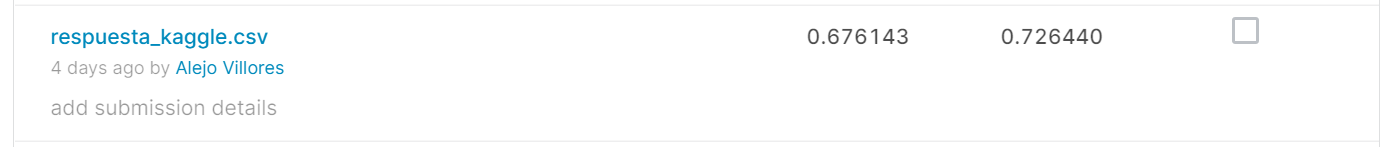